## Congestion Statge Estimator (CSE) Training

__1. Training Data:__

    - Data collection: Ring (all 22 vehicles inluding RL are kept as IDM)
    - The data is collected at initial configuration of vehicles equally spaced, for for a brief time there will be stable conditions.
    - 400 simulation runs are performed each with a warmup time of 2500 and horizon of 0. This was based on the observation that test accuracy gets better with more data.
    
__2. Neural Network configuration:__

    - Same neural network may have to be scaled to numerous densities
    
__3. Data Processing:__

    - The collected data mostly contains non-transition data.
    - It is filtered and made equally representative of transition and non-transition (50% each).
    - Further, the data is also made equally representative of the 5 (out of  6) class labels.
    - Perhaps, as additional safety the sixth one (with no car in front has also to be added in the future)
    
__Additional Notes:__

    - Essentially, the TSE predicts if the RL vehicle were IDM, then what would be the expected traffic state 10-timesteps into the future.

In [1]:
import os
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Load data into one single structure

#works with multiple npy files, stacks the data read from each file
files = os.listdir('./tse_data')
npy_files = [file for file in files if file.endswith('.npy')]
print(f"Total {len(npy_files)} files", end = "\n\n")

all_data = []
for file in npy_files:
    data = np.load('./tse_data/'+ file, allow_pickle=True)
    #print(f"{data.shape}\t{data[:, 0].shape}\t{data[:, 1].shape}\t{data[:, 2].shape}\n")
    all_data.extend(data)

all_data = np.array(all_data)
print(f"{all_data.shape}\n{all_data[:, 0].shape}\n{all_data[:, 1].shape}\n{all_data[:, 2].shape}")

# Print the shape of first item of the observations, and the first 10 items of the timesteps and labels
print(f"\n{all_data[:, 0][0:10]}\n{all_data[:, 1][0:10]}\n{all_data[:, 2][0].shape}")

# [:,0] is timesteps
# [:,1] is labels
# [:,2] is observations

Total 400 files

(1000000, 3)
(1000000,)
(1000000,)
(1000000,)

[0 1 2 3 4 5 6 7 8 9]
[1 2 2 2 2 2 2 2 2 2]
(10, 2)


In [4]:
# TIME_WINDOW
TIMESTEP_OFFSET = 10

X = all_data[:, 2] # Observations
y = all_data[:, 1] # TSE labels

print(f"Before offset, X: {X.shape}, y:{y.shape}")

# Go from 0 to (last - TIME_OFFSET)
X = X[0: X.shape[0]-TIMESTEP_OFFSET]

# Go from 0 to (last - TIME_OFFSET)
y_current = y[0: y.shape[0]-TIMESTEP_OFFSET]

# Go from 10 to last
y_future = y[TIMESTEP_OFFSET:]
      
print(f"After offset, X: {X.shape}, y_current:{y_current.shape}, y_future:{y_future.shape}\n")

Before offset, X: (1000000,), y:(1000000,)
After offset, X: (999990,), y_current:(999990,), y_future:(999990,)



In [5]:
def display_counts(indices, labels):
    
    num_non_transition = sum(len(indices['non-transition'][label]) for label in labels)
    num_transition = sum(len(indices['transition'][label]) for label in labels)

    print(f'Number of non-transitions: {num_non_transition}')
    print(f'Number of transitions: {num_transition}')
    print(f"In percentage Transitions are: {round(100*(num_transition/num_non_transition),2)}%\n")

    # Count the occurrences of each label
    print(f'Non-transition ({num_non_transition}) counts by label:')
    for label in sorted(labels):
        this_count = len(indices['non-transition'][label])
        print(f'\t{label_meanings[label]}: {this_count}, percentage: {round(100*(this_count/num_non_transition),2)}%')

    print(f'\nTransition ({num_transition}) counts by label:')
    for label in sorted(labels):
        this_count = len(indices['transition'][label])
        print(f'\t{label_meanings[label]}: {this_count}, percentage: {round(100*(this_count/num_transition),2)}%')

In [6]:
# Two objectives:
# Transition and non-transition data must be balanced
# The 6 (5 in actual) labels must be balanced

labels = [0, 1, 2, 3, 4, 5]
# 0 = Leaving, 1 = Forming, 2 = Free Flow, 3 = Congested, 4 undefined, 5 No vehicle in front
label_meanings = ["Leaving", "Forming", "Free Flow", "Congested", "undefined", "No vehicle in front"]
                  
indices = {'transition': {key: [] for key in labels},
           'non-transition': {key: [] for key in labels}}

# If y_future and y_current have same label, its non-transition data
# If they have different labels, its transition data
for i, (current, future) in enumerate(zip(y_current, y_future)):
    # non-transition
    if current == future:  
        indices['non-transition'][current].append(i)
    # transition
    else:  
        indices['transition'][future].append(i)

# The No vehicles in front case.
# It does not make much sense to have "no vehicles in front" to have a transition 
# Based on the information that at present timestep there are no vehicles in front, you cannot predict the future
# The control action is also deterministic in this case (accelerate to reach speed limit)
# So, generate some synthetic data to represent this case

display_counts(indices, labels)

# Perform selection
# Whichever among all (transition and non-trainsition) has the lowest counts, pick everything to be that number
actual_labels = [0, 1, 2, 3, 4] # Exclude No vehicle in front for the next couple of steps

lowest_transition = min(len(indices['transition'][label]) for label in actual_labels)
lowest_non_transition = min(len(indices['non-transition'][label]) for label in actual_labels)
lowest = min(lowest_transition, lowest_non_transition)

print(f"\nLowest: {lowest} data points\n")

# select randomly
selected_indices = {'transition': {key: [] for key in actual_labels},
                    'non-transition': {key: [] for key in actual_labels}}

for kind in ['transition', 'non-transition']:
    for label in actual_labels:
        if indices[kind][label]:
            # Randomly select and add
            selected_indices[kind][label] = random.sample(indices[kind][label], lowest) 

display_counts(selected_indices, actual_labels)

Number of non-transitions: 847318
Number of transitions: 152672
In percentage Transitions are: 18.02%

Non-transition (847318) counts by label:
	Leaving: 444159, percentage: 52.42%
	Forming: 57288, percentage: 6.76%
	Free Flow: 159954, percentage: 18.88%
	Congested: 232, percentage: 0.03%
	undefined: 185685, percentage: 21.91%
	No vehicle in front: 0, percentage: 0.0%

Transition (152672) counts by label:
	Leaving: 47040, percentage: 30.81%
	Forming: 13396, percentage: 8.77%
	Free Flow: 38988, percentage: 25.54%
	Congested: 3175, percentage: 2.08%
	undefined: 50073, percentage: 32.8%
	No vehicle in front: 0, percentage: 0.0%

Lowest: 232 data points

Number of non-transitions: 1160
Number of transitions: 1160
In percentage Transitions are: 100.0%

Non-transition (1160) counts by label:
	Leaving: 232, percentage: 20.0%
	Forming: 232, percentage: 20.0%
	Free Flow: 232, percentage: 20.0%
	Congested: 232, percentage: 20.0%
	undefined: 232, percentage: 20.0%

Transition (1160) counts by lab

In [7]:
# Generate the same number (as lowest) of synthetic data for No vehicles in front
# The first vehicle is RL (itself) will have some data

no_veh_data = np.full((lowest, 20), -1.0)
for i in range(lowest):
    # Generate two random numbers between 0 and 1 and fill
    random_numbers = np.random.rand(2)
    no_veh_data[i, :2] = random_numbers
    
no_veh_labels = np.full((lowest,), 5)
print(no_veh_data.shape, no_veh_labels.shape)
print(no_veh_data[100])

(232, 20) (232,)
[ 0.82088644  0.09463344 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]


In [8]:
# Select the corresponsing observations as well
X_dataset = []
y_dataset = []

# add real data
for kind in ['transition', 'non-transition']:
    for label in actual_labels:
        for index in selected_indices[kind][label]:
            X_dataset.append(X[index].flatten())
            y_dataset.append(y_future[index])
    
X_dataset = np.array(X_dataset)
y_dataset = np.array(y_dataset)

#add synthethic data 
X_dataset = np.append(X_dataset, no_veh_data, axis=0)
y_dataset = np.append(y_dataset, no_veh_labels, axis=0)

print(X_dataset.shape, y_dataset.shape)

# Validation that the data operation was correctly done
# This works, do not remove
# Select a few indices from here
# for i in actual_labels:
#     print(selected_indices['non-transition'][i][0:2])
#     print(selected_indices['transition'][i][0:2])
# random_indices = [271567, 7646, 199950, 144989]

# for i in random_indices:
#     print(f"\n\n{i}")
#     data =X[i].flatten()
#     print(f"Observation:{data, data.shape}")
#     print(f"Future Label:\t{y_future[i]}")
    
#     # Find the index of 'data' in 'X_dataset'
#     match_index = None
#     for j, x in enumerate(X_dataset):
#         if np.array_equal(x, data):
#             match_index = j
#             break
#     print(f"Match Index in X_dataset: {match_index}")
#     print(f"Found in Dataset X: {X_dataset[match_index]}\nWith Label: {y_dataset[match_index]}\n")
# X_dataset.shape

(2552, 20) (2552,)


/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


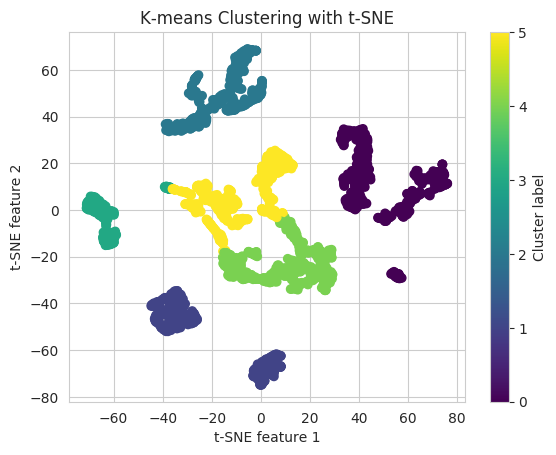

In [9]:
# Visulaization of the observations (position, velocity), cluster of the 5 categories

# Reshape each (10, 2) array into a 20-element vector
X_flattened = X_dataset #np.array([x.flatten() for x in X_dataset])

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_flattened) # if t-SNE is slow; only use a subset

# Apply K-means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_reduced)

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Plot the data, colored by cluster assignment
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering with t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Cluster label')
plt.show()

In [10]:
# # split into train, val, and test (70%, 20%, 10%)
# X_train, X_temp, y_train, y_temp = train_test_split(X_dataset, y_dataset, test_size=0.3, random_state=SEED)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=SEED)

# # Printing the shapes of the resulting datasets
# print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
# print(f"Test set: X_test: {X_test.shape}, y_val: {y_test.shape}")

# Considering we have small amount of data, split into train, val=test (85%, 15%)
X_train, X_val, y_train, y_val = train_test_split(X_dataset, y_dataset, test_size=0.15, random_state=SEED, stratify=y_dataset)
X_test = X_val
y_test = y_val

# Printing the shapes of the resulting datasets
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_val: {y_test.shape}")

Training set: X_train: (2169, 20), y_train: (2169,)
Validation set: X_val: (383, 20), y_val: (383,)
Test set: X_test: (383, 20), y_val: (383,)


In [11]:
# PT helpers
class TrafficDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TSE_Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TSE_Net, self).__init__() 
        self.fc1 = nn.Linear(input_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(16, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [12]:
def train(net, train_loader, criterion, optimizer, print_every):
    net.train() 
    running_loss = 0.0
    track_running_loss = []
    for i, bdata in enumerate(train_loader, 0):
        inputs, labels = bdata
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % print_every == print_every - 1:
            running_loss = running_loss / print_every
            track_running_loss.append(running_loss)
            print(f"Training - Batch: {i+1}, Loss: {running_loss:.4f}")
            running_loss = 0.0
            
    return track_running_loss 

def validate(net, val_loader, criterion):
    net.eval()  
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_outputs = net(val_inputs)
            val_batch_loss = criterion(val_outputs, val_labels)
            val_loss += val_batch_loss.item()

            # accuracy
            _, predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return val_loss

In [13]:
input_size = X_train.shape[1]  # 20
num_classes = len(np.unique(y_dataset))  # 6
net = TSE_Net(input_size, num_classes)

n_epochs = 500
batch_size = 32
print_every = 50

print(f"The model has {count_parameters(net):} trainable parameters")
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(net.parameters(), lr=0.01)

train_data = TrafficDataset(torch.tensor(X_train, dtype=torch.float32), 
                             torch.tensor(y_train.astype(int), dtype=torch.long))

val_data = TrafficDataset(torch.tensor(X_val, dtype=torch.float32), 
                           torch.tensor(y_val.astype(int), dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
train_loss_values = []
epoch_train_loss_values = []
val_loss_values = []

for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}", end = "\t")
    track_running_loss = train(net, train_loader, criterion, optimizer, print_every)
    val_loss = validate(net, val_loader, criterion)
    
    val_loss_values.append(val_loss)
    train_loss_values.extend(track_running_loss)
    epoch_train_loss_values.append(np.mean(track_running_loss))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        
        save_path = './saved_models/'
        os.makedirs(save_path, exist_ok=True)
        torch.save(net.state_dict(), os.path.join(save_path, 'best_cse_model.pt'))
        
        print("###### New model saved ######")

The model has 1302 trainable parameters
Epoch: 1	Training - Batch: 50, Loss: 1.2736
Validation - Loss: 1.0121, Accuracy: 51.44%
###### New model saved ######
Epoch: 2	Training - Batch: 50, Loss: 0.9832
Validation - Loss: 0.9731, Accuracy: 51.44%
###### New model saved ######
Epoch: 3	Training - Batch: 50, Loss: 0.9391
Validation - Loss: 0.9315, Accuracy: 53.00%
###### New model saved ######
Epoch: 4	Training - Batch: 50, Loss: 0.8869
Validation - Loss: 0.8277, Accuracy: 67.10%
###### New model saved ######
Epoch: 5	Training - Batch: 50, Loss: 0.8077
Validation - Loss: 0.7751, Accuracy: 61.10%
###### New model saved ######
Epoch: 6	Training - Batch: 50, Loss: 0.7172
Validation - Loss: 0.6778, Accuracy: 67.36%
###### New model saved ######
Epoch: 7	Training - Batch: 50, Loss: 0.6536
Validation - Loss: 0.6991, Accuracy: 72.06%
Epoch: 8	Training - Batch: 50, Loss: 0.5905
Validation - Loss: 0.5336, Accuracy: 79.11%
###### New model saved ######
Epoch: 9	Training - Batch: 50, Loss: 0.5852
Va

Epoch: 89	Training - Batch: 50, Loss: 0.3440
Validation - Loss: 0.2608, Accuracy: 90.86%
Epoch: 90	Training - Batch: 50, Loss: 0.3145
Validation - Loss: 0.2567, Accuracy: 90.86%
Epoch: 91	Training - Batch: 50, Loss: 0.3420
Validation - Loss: 0.2617, Accuracy: 88.51%
Epoch: 92	Training - Batch: 50, Loss: 0.3700
Validation - Loss: 0.2743, Accuracy: 87.99%
Epoch: 93	Training - Batch: 50, Loss: 0.2966
Validation - Loss: 0.2694, Accuracy: 90.08%
Epoch: 94	Training - Batch: 50, Loss: 0.3014
Validation - Loss: 0.2663, Accuracy: 88.77%
Epoch: 95	Training - Batch: 50, Loss: 0.2970
Validation - Loss: 0.2810, Accuracy: 90.86%
Epoch: 96	Training - Batch: 50, Loss: 0.3057
Validation - Loss: 0.2717, Accuracy: 91.12%
Epoch: 97	Training - Batch: 50, Loss: 0.3441
Validation - Loss: 0.2604, Accuracy: 89.56%
Epoch: 98	Training - Batch: 50, Loss: 0.3457
Validation - Loss: 0.3166, Accuracy: 88.51%
Epoch: 99	Training - Batch: 50, Loss: 0.2906
Validation - Loss: 0.2595, Accuracy: 89.03%
Epoch: 100	Training -

Epoch: 180	Training - Batch: 50, Loss: 0.2488
Validation - Loss: 0.2764, Accuracy: 87.47%
Epoch: 181	Training - Batch: 50, Loss: 0.3248
Validation - Loss: 0.2776, Accuracy: 88.25%
Epoch: 182	Training - Batch: 50, Loss: 0.2973
Validation - Loss: 0.2628, Accuracy: 89.03%
Epoch: 183	Training - Batch: 50, Loss: 0.2815
Validation - Loss: 0.2614, Accuracy: 89.30%
Epoch: 184	Training - Batch: 50, Loss: 0.2589
Validation - Loss: 0.2521, Accuracy: 92.17%
Epoch: 185	Training - Batch: 50, Loss: 0.2678
Validation - Loss: 0.2829, Accuracy: 89.03%
Epoch: 186	Training - Batch: 50, Loss: 0.2578
Validation - Loss: 0.2559, Accuracy: 91.64%
Epoch: 187	Training - Batch: 50, Loss: 0.2964
Validation - Loss: 0.2665, Accuracy: 87.73%
Epoch: 188	Training - Batch: 50, Loss: 0.2651
Validation - Loss: 0.2926, Accuracy: 88.25%
Epoch: 189	Training - Batch: 50, Loss: 0.3023
Validation - Loss: 0.4308, Accuracy: 83.29%
Epoch: 190	Training - Batch: 50, Loss: 0.3102
Validation - Loss: 0.2366, Accuracy: 91.64%
Epoch: 191

###### New model saved ######
Epoch: 272	Training - Batch: 50, Loss: 0.2618
Validation - Loss: 0.2910, Accuracy: 89.56%
Epoch: 273	Training - Batch: 50, Loss: 0.2330
Validation - Loss: 0.2544, Accuracy: 89.82%
Epoch: 274	Training - Batch: 50, Loss: 0.3243
Validation - Loss: 0.2519, Accuracy: 89.03%
Epoch: 275	Training - Batch: 50, Loss: 0.2699
Validation - Loss: 0.2398, Accuracy: 90.08%
Epoch: 276	Training - Batch: 50, Loss: 0.2591
Validation - Loss: 0.2319, Accuracy: 91.38%
Epoch: 277	Training - Batch: 50, Loss: 0.2641
Validation - Loss: 0.3431, Accuracy: 86.95%
Epoch: 278	Training - Batch: 50, Loss: 0.2839
Validation - Loss: 0.2782, Accuracy: 88.77%
Epoch: 279	Training - Batch: 50, Loss: 0.2345
Validation - Loss: 0.2798, Accuracy: 87.99%
Epoch: 280	Training - Batch: 50, Loss: 0.2514
Validation - Loss: 0.2654, Accuracy: 88.77%
Epoch: 281	Training - Batch: 50, Loss: 0.2571
Validation - Loss: 0.2310, Accuracy: 92.69%
Epoch: 282	Training - Batch: 50, Loss: 0.2492
Validation - Loss: 0.220

Epoch: 366	Training - Batch: 50, Loss: 0.2537
Validation - Loss: 0.2057, Accuracy: 90.86%
Epoch: 367	Training - Batch: 50, Loss: 0.2391
Validation - Loss: 0.2850, Accuracy: 88.25%
Epoch: 368	Training - Batch: 50, Loss: 0.2496
Validation - Loss: 0.2337, Accuracy: 90.34%
Epoch: 369	Training - Batch: 50, Loss: 0.2769
Validation - Loss: 0.2245, Accuracy: 92.17%
Epoch: 370	Training - Batch: 50, Loss: 0.2454
Validation - Loss: 0.2495, Accuracy: 89.30%
Epoch: 371	Training - Batch: 50, Loss: 0.2300
Validation - Loss: 0.2328, Accuracy: 91.12%
Epoch: 372	Training - Batch: 50, Loss: 0.2893
Validation - Loss: 0.2457, Accuracy: 89.82%
Epoch: 373	Training - Batch: 50, Loss: 0.2584
Validation - Loss: 0.2677, Accuracy: 88.25%
Epoch: 374	Training - Batch: 50, Loss: 0.2491
Validation - Loss: 0.3063, Accuracy: 88.25%
Epoch: 375	Training - Batch: 50, Loss: 0.2263
Validation - Loss: 0.2636, Accuracy: 88.25%
Epoch: 376	Training - Batch: 50, Loss: 0.2699
Validation - Loss: 0.2568, Accuracy: 91.12%
Epoch: 377

Epoch: 460	Training - Batch: 50, Loss: 0.2379
Validation - Loss: 0.2454, Accuracy: 90.08%
Epoch: 461	Training - Batch: 50, Loss: 0.2094
Validation - Loss: 0.2371, Accuracy: 89.30%
Epoch: 462	Training - Batch: 50, Loss: 0.2374
Validation - Loss: 0.2358, Accuracy: 89.82%
Epoch: 463	Training - Batch: 50, Loss: 0.2389
Validation - Loss: 0.2397, Accuracy: 92.43%
Epoch: 464	Training - Batch: 50, Loss: 0.2561
Validation - Loss: 0.2193, Accuracy: 91.38%
Epoch: 465	Training - Batch: 50, Loss: 0.2417
Validation - Loss: 0.2798, Accuracy: 88.77%
Epoch: 466	Training - Batch: 50, Loss: 0.2231
Validation - Loss: 0.2262, Accuracy: 89.30%
Epoch: 467	Training - Batch: 50, Loss: 0.2407
Validation - Loss: 0.2253, Accuracy: 92.69%
Epoch: 468	Training - Batch: 50, Loss: 0.2210
Validation - Loss: 0.2426, Accuracy: 91.12%
Epoch: 469	Training - Batch: 50, Loss: 0.2510
Validation - Loss: 0.2483, Accuracy: 89.56%
Epoch: 470	Training - Batch: 50, Loss: 0.2379
Validation - Loss: 0.2175, Accuracy: 91.38%
Epoch: 471

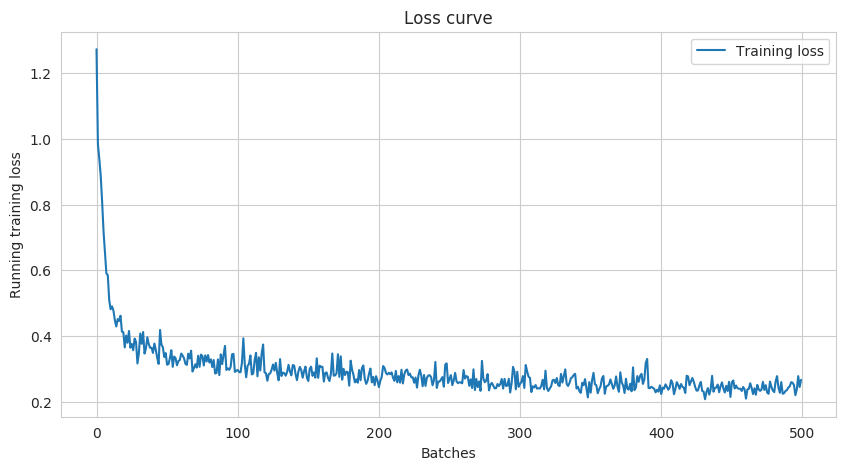

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label = "Training loss")
plt.title('Loss curve')
plt.xlabel('Batches')
plt.ylabel('Running training loss')
plt.legend()

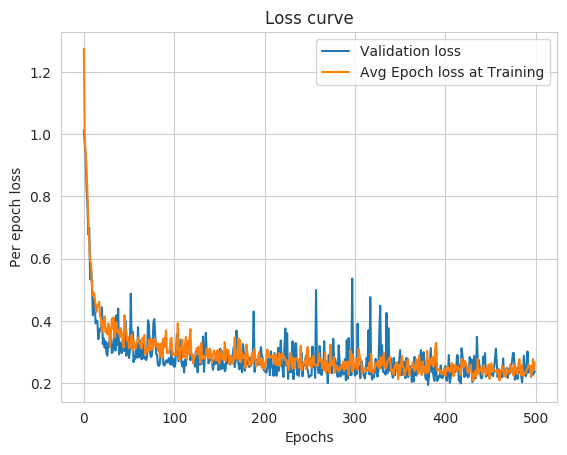

In [15]:
plt.plot(val_loss_values, label="Validation loss")
plt.plot(epoch_train_loss_values, label="Avg Epoch loss at Training")
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Per epoch loss')
plt.legend()

In [16]:
best_model_path = './saved_models/best_cse_model.pt'

input_size = 10*2
num_classes = 6

saved_best_net = TSE_Net(input_size, num_classes)
saved_best_net.load_state_dict(torch.load(best_model_path))
saved_best_net.eval()

TSE_Net(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)

In [17]:
# random_input = torch.randn(10, 2).flatten()
# print(random_input)

# with torch.no_grad():
#     outputs = saved_best_net(random_input.unsqueeze(0))

# _, predicted_label = torch.max(outputs, 1)
# predicted_label = predicted_label.numpy()

# print(predicted_label)

Test accuracy: 92.69%


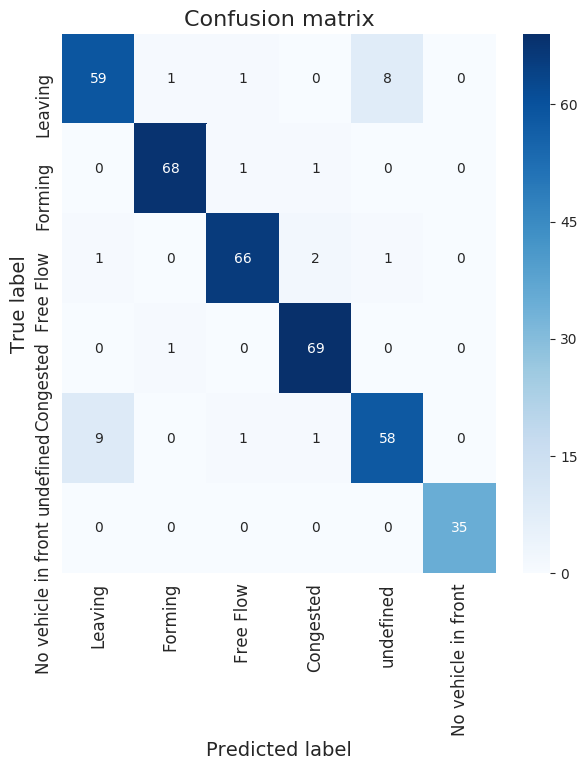

In [18]:
# Analyze: In the validation set what did the best model get wrong?
# Perform this on the test set

label_meanings = ["Leaving", "Forming", "Free Flow", "Congested", "undefined", "No vehicle in front"]

# Get confusion matrix 
y_test_pred = []
with torch.no_grad():
    for x in X_test:
        outputs = saved_best_net(torch.from_numpy(x).float().unsqueeze(0)) # Dataloader makes it float at training
        _, predicted_label = torch.max(outputs, 1)
        y_test_pred.append(predicted_label.numpy()[0])
y_test_pred = np.array(y_test_pred)

# Calculate accuracy on the test set
test_accuracy = np.mean(y_test_pred == y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_test_pred)

fs = 16
fig, ax = plt.subplots(figsize=(7,7), dpi = 100)
ax.tick_params(axis='both', which='major', labelsize=fs-4)
sns.heatmap(cm, annot=True, fmt="d", 
            cmap='Blues', 
            xticklabels=label_meanings, 
            yticklabels=label_meanings)

ax.set_title('Confusion matrix', fontsize=fs)
ax.set_xlabel('Predicted label',fontsize=fs-2)
ax.set_ylabel('True label', fontsize=fs-2)
plt.show()

In [19]:
# To decide how many timesteps into the figure to use
# Look at the error rate (test accuracy) vs timestep number